In [ ]:
    # Mask on Urban Centre and Locality (UCL) Ed. 2016 for bare areas
    UCL_mask:
        ingest_class: gridded_ingest.LEIngestGDAL
        input_file: s3://dea-public-data/projects/LCCS/urban_mask.tif 
        band: 1
        expstr: "(band == 1)"

In [15]:
import os, sys, copy
import yaml
import numpy as np
import xarray as xr
import pickle

from itertools import groupby
from matplotlib import pyplot as plt
import matplotlib.gridspec as gridspec

import datacube
from datacube.storage import masking
from datacube.virtual import catalog_from_file
from datacube.utils.geometry import CRS
from datacube.helpers import write_geotiff

import importlib
from datacube.virtual import DEFAULT_RESOLVER
from datacube.testutils.io import rio_slurp_xarray

dc = datacube.Datacube()

In [16]:
# AWS or Gadi
service = '/home/jovyan/development/'

sys.path.append(str(service)+"dea-notebooks/Scripts")
from dea_classificationtools import sklearn_unflatten
from dea_classificationtools import sklearn_flatten

sys.path.append(str(service)+"livingearth_lccs")
from le_lccs.le_ingest import gridded_ingest

sys.path.append(str(service)+"livingearth_australia")
import le_plugins

sys.path.append(os.path.abspath(str(service)+"livingearth_australia/le_plugins"))

In [33]:
# loading extents from yaml Dan prepared, just change site_name to tile interested in from our 16 test sites
# yaml_sites_file = os.path.abspath(str(service)+"livingearth_australia/vec_rois/au_test_sites.yaml")
yaml_sites_file = os.path.abspath(str(service)+"chris_leaust_testing/notebooks/misc/au_test_sites.yaml")

with open(yaml_sites_file, "r") as f:
    site_config = yaml.safe_load(f)

site_name = "Adelaide"
extent_x = [site_config[site_name]["min_x"],
            site_config[site_name]["max_x"]]
extent_y = [site_config[site_name]["min_y"],
            site_config[site_name]["max_y"]]

crs = "EPSG:3577"
res = (-100, 100)
time = ("2015-01-01", "2015-12-31")
query =({'time': time,
             'x':extent_x,
            'y':extent_y,
            'crs':crs,
            'resolution':res})

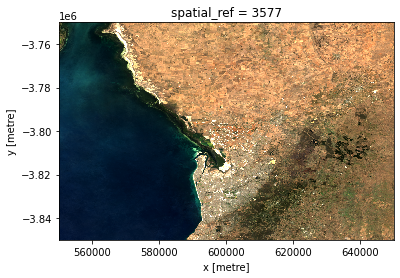

In [34]:
# Load Landsat
geomedian = dc.load(product="ls8_nbart_geomedian_annual", **query)
geomedian = masking.mask_invalid_data(geomedian).squeeze().drop('time')
geomedian[['red', 'green', 'blue']].to_array().plot.imshow(robust=True)

In [35]:
# datacube functions to load in a virtual product from recipe
catalog = catalog_from_file(service+'livingearth_australia/le_plugins/virtual_product_cat.yaml')

In [36]:
# best geomedian for saltpan_mask and mudflat mask
product = catalog['best_pixel_gm']
best_pixel_gm = product.load(dc, **query)
best_pixel_gm

<xarray.Dataset>
Dimensions:      (time: 1, x: 1000, y: 1000)
Coordinates:
    spatial_ref  int32 3577
  * x            (x) float64 5.500e+05 5.502e+05 5.502e+05 ... 6.498e+05 6.5e+05
  * y            (y) float64 -3.75e+06 -3.75e+06 ... -3.85e+06 -3.85e+06
  * time         (time) datetime64[ns] 2015-01-01
Data variables:
    blue         (time, y, x) float32 825.0 843.0 849.0 ... 465.0 548.0 563.0
    green        (time, y, x) float32 1159.0 1185.0 1208.0 ... 658.0 796.0 811.0
    red          (time, y, x) float32 1474.0 1489.0 1495.0 ... 1064.0 1063.0
    nir          (time, y, x) float32 2606.0 2711.0 2824.0 ... 2313.0 2428.0
    swir1        (time, y, x) float32 3356.0 3487.0 3654.0 ... 2636.0 2567.0
    swir2        (time, y, x) float32 2567.0 2602.0 2710.0 ... 1923.0 1801.0
Attributes:
    crs:           EPSG:3577
    grid_mapping:  spatial_ref

In [37]:
# collate all data for manual application of plugin
variables_xarray_list = []
variables_xarray_list.append(best_pixel_gm)

# Merge to a single dataframe
data_collate = xr.merge(variables_xarray_list)

year = str(data_collate.time.data[0])
data = data_collate.squeeze(dim='time', drop=True)

In [38]:
# load DEM
urban = rio_slurp_xarray("s3://dea-public-data/projects/LCCS/urban_mask.tif", gbox=data.geobox)

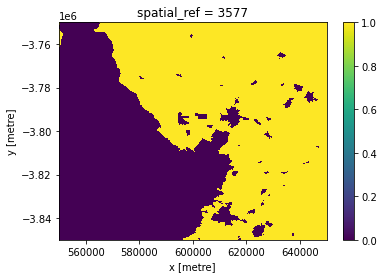

In [39]:
urban.plot()